In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
import seaborn as sns
from scipy.signal import butter,filtfilt,welch
from scipy import signal
import optuna
import numpy as np  
import optuna.visualization as vis
import plotly

/usr/lib/python3/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
low_cutoff = 0.01  # Low cut-off frequency (Hz)
high_cutoff = 70.0  # High cut-off frequency (Hz)
order = 4  # Order of the filter
sampling_rate_equipo= 500 
b, a = signal.butter(order, [low_cutoff / (0.5 * sampling_rate_equipo), high_cutoff / (0.5 * sampling_rate_equipo)], btype='band')

In [22]:
fs = 500  # Sampling rate
nperseg = 256  # Segment length
noverlap = 128 # Overlap between segments
sampling_rate = 2000 ### simulacion 

resultado_compilacion = subprocess.run("g++ -fopenmp -O3 main.cpp Matrix_conect.cpp -o main", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
if resultado_compilacion.returncode != 0:
    print("Error durante la compilación:")
    print(resultado_compilacion.stderr)

def Simulado_EGG(params):
    L, P, inhibidoras, trest, trelative, alpha, tmax, type_matrix = params
        
    # Ejecución del programa
    resultado_ejecucion = subprocess.run(f"./main {L} {P} {inhibidoras} {trest} {trelative} {alpha} {tmax} {type_matrix}", shell=True, stdout=subprocess.PIPE, stderr=subprocess.PIPE, text=True)
    if resultado_ejecucion.returncode != 0:
        print("Error durante la ejecución:")
        print(resultado_ejecucion.stderr)
        return None
    
    # Procesamiento de los datos
    lines = resultado_ejecucion.stdout.strip().split('\n')
    data_list = [[float(num) for num in line.split()] for line in lines]
    data = np.array(data_list)[30:, 1]
    
    # data=(data) / np.max(data) 
    # #data=(data - np.min(data)) / (np.max(data) - np.min(data))
    data=(data - np.mean(data)) / np.std(data)
    
    n_samples_resampled = int(len(data)*(fs/sampling_rate))
    data_resampled = signal.resample(data, n_samples_resampled)

    butter = signal.filtfilt(b, a,data_resampled)

    frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
    frequencies=np.array(frequencies)


    welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
    
    delta = welch_data[np.logical_and(frequencies >= 0, frequencies <= 3)]
    theta = welch_data[np.logical_and(frequencies >= 3, frequencies <= 7)]
    alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 14)]
    beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

    return {
        'data': data,"data_resample":data_resampled,"butter": butter,
        "frequencies": frequencies,"welch_data":welch_data,
        'delta':[delta.mean(),delta.std()],
        'theta':[theta.mean(), theta.std()],
        'alpha':[ alpha.mean(),alpha.std()],
        'beta': [beta.mean(), beta.std()]
    }



# Datos Reales

 Tanto como los datos reales como lo simulados pueden ser normlaizados(por su maximo), los valores real estan en microvoltios, en la simulacion estan con 0.00070 microvoltios reposo 

In [23]:
def Datos_reales(nombres):
    Datos = np.empty(len(nombres), dtype=object)
    Butter = np.empty(len(nombres), dtype=object)
    welch_datos = np.empty(len(nombres), dtype=object)
    Frequencies = np.empty(len(nombres), dtype=object)
    Delta = np.empty(len(nombres), dtype=object)
    Theta = np.empty(len(nombres), dtype=object)
    Alpha = np.empty(len(nombres), dtype=object)
    Beta = np.empty(len(nombres), dtype=object)
    Nombres=np.empty(len(nombres), dtype="U100")

    # Inicialización de arrays para promedios de bandas
    main_Delta = np.zeros(2)
    main_Theta = np.zeros(2)
    main_Alpha = np.zeros(2)
    main_Beta = np.zeros(2)
    for i, nombre in enumerate(nombres):  
        Nombres[i]=nombre 


        data = np.loadtxt(nombre)
        # data=(data) / np.max(data) 
        # #data=(data - np.min(data)) / (np.max(data) - np.min(data))
        data=(data - np.mean(data)) / np.std(data)
        Datos[i]=data

        Butter[i]=butter= signal.filtfilt(b, a,data)

        frequencies, psd = signal.welch(butter, fs, nperseg=nperseg, noverlap=noverlap)
        Frequencies[i]=frequencies=np.array(frequencies)

        welch_data = np.array([10 * np.log10(psd[i]+ 1e-10) for i in range(len(frequencies))])
        welch_datos[i]=welch_data

        delta = welch_data[np.logical_and(frequencies >= 1, frequencies <= 3)]
        theta = welch_data[np.logical_and(frequencies >= 4, frequencies <= 7)]
        alpha = welch_data[np.logical_and(frequencies >= 7, frequencies <= 13)]
        beta = welch_data[np.logical_and(frequencies >= 14, frequencies <= 30)]

        Delta[i]=[delta.mean(),delta.std()]
        Theta[i]=[theta.mean(),theta.std()]
        Alpha[i]=[alpha.mean(),alpha.std()]
        Beta[i]=[beta.mean(),beta.std()]

        main_Delta += np.array([delta.mean(), delta.std()]) / len(nombres)
        main_Theta += np.array([theta.mean(), theta.std()]) / len(nombres)
        main_Alpha += np.array([alpha.mean(), alpha.std()]) / len(nombres)
        main_Beta += np.array([beta.mean(), beta.std()]) / len(nombres)

    return {
        "Nombres":Nombres,
        'datos': Datos,"buter":Butter, "frequencies": Frequencies,  "welch_data":welch_datos,
        'delta':Delta,'theta':Theta,'alpha':Alpha,'beta':Beta,
        'main_Delta': main_Delta,'main_Theta':main_Theta,"main_Alpha":main_Alpha,"main_Beta":main_Beta
    }


In [21]:
Params={'L': 75, 'P': 0.9622783999738151, 'Inh': 0.2955980222274488, 'Trest': 9.445498392645192, 'Trelative': 15.993853711483407, 'C_h': 27.20385600723999, 'Tipo_red': 1}
initial_params = [Params["L"], Params["P"],Params["Inh"], Params["Trest"],Params["Trelative"], Params["C_h"] ,8030,1]
generated_data = Simulado_EGG(initial_params)
reales_total = Datos_reales(["P3_MNE.txt","Pz_MNE.txt","P4_MNE.txt"])

/tmp/ipykernel_4053/2146946808.py:30: RuntimeWarning:

invalid value encountered in divide



['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']


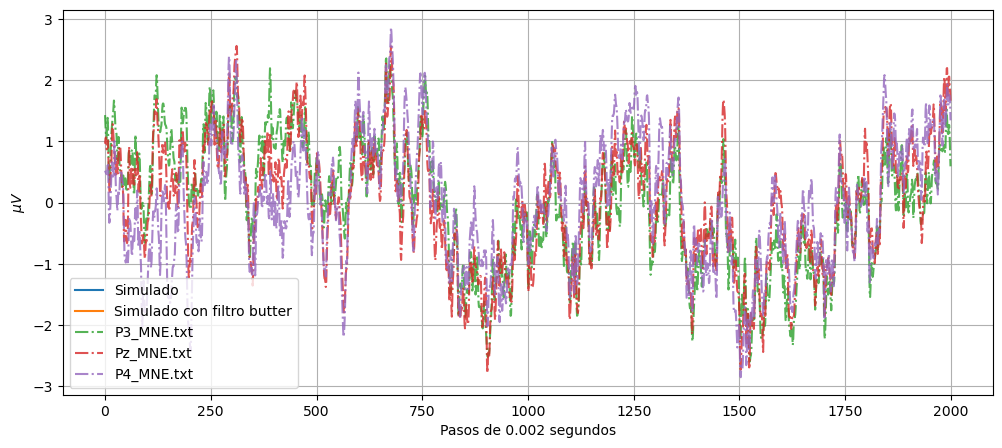

In [24]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
ax.plot(generated_data["data_resample"],label="Simulado")
ax.plot(generated_data["butter"],label="Simulado con filtro butter")
for i in range(3):
    ax.plot(reales_total["datos"][i],"-.", label=reales_total["Nombres"][i],alpha=0.8)


plt.xlabel("Pasos de 0.002 segundos")
plt.ylabel(r"$\mu V$")
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.grid()
plt.show()  # Mostrar todos los gráficos en la misma figura


['P3_MNE.txt' 'Pz_MNE.txt' 'P4_MNE.txt']
Delta [nan, nan] ---- [-11.74808952   0.        ]
Theta [nan, nan] ---- [-15.54299001   0.        ]
Alpha [nan, nan] ---- [-17.20623753   1.28777367]
Beta [nan, nan] ---- [-24.65127747   1.55043901]


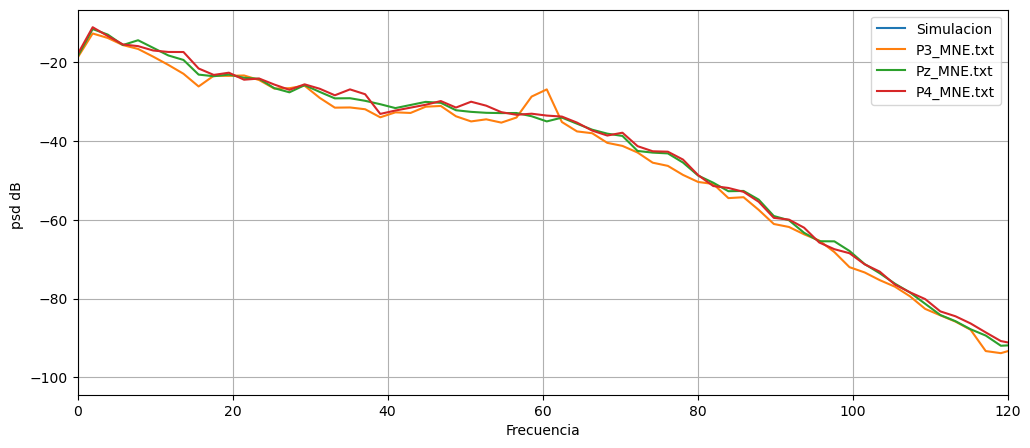

In [25]:
fig, ax = plt.subplots(figsize=[12, 5])

print(reales_total["Nombres"])
print("Delta",generated_data["delta"],"----",reales_total["main_Delta"])
print("Theta",generated_data["theta"],"----",reales_total["main_Theta"])
print("Alpha",generated_data["alpha"],"----",reales_total["main_Alpha"])
print("Beta",generated_data["beta"],"----",reales_total["main_Beta"])

ax.plot(generated_data["frequencies"],generated_data["welch_data"],label="Simulacion")
for i in range(3):
    ax.plot(reales_total["frequencies"][i],reales_total["welch_data"][i], label=reales_total["Nombres"][i])

plt.xlabel("Frecuencia")
plt.ylabel("psd dB ")
plt.xlim(0,120)
plt.grid()
plt.legend()  # Esto añade una leyenda para identificar cada línea
plt.show()  # Mostrar todos los gráficos en la misma figura


In [29]:

def objective(trial):
    params = np.zeros(8)
    params[0] = trial.suggest_int('L',20,50)
    params[1] = trial.suggest_float('P', 0.0, 1.0)
    params[2] = trial.suggest_float('Inh', 0.0, 1.0)
    params[3] = trial.suggest_float('Trest', -10.0, 10.0)###, step=0.05 difernecia entre datos 
    params[4] = trial.suggest_float('Trelative',params[3],params[3]+10)  
    params[5] = trial.suggest_float('C_h', 0, 50)
    params[6] = 8030
    params[7] = trial.suggest_int('Tipo_red',1,2)

    
    generated_data_total = Simulado_EGG(params)
    if generated_data_total["delta"][1]-generated_data_total["delta"][1]==0:
        dif_Delta=generated_data_total["delta"]-reales_total["main_Delta"]
        dif_Theta=generated_data_total["theta"]-reales_total["main_Theta"]
        dif_Alpha=generated_data_total["alpha"]-reales_total["main_Alpha"]
        dif_Beta=generated_data_total["beta"]-reales_total["main_Beta"]
        difference = (np.sum(np.abs(dif_Delta)) +
                            np.sum(np.abs(dif_Theta)) +
                            np.sum(np.abs(dif_Alpha)) +
                            np.sum(np.abs(dif_Beta)))

        trial.report(difference, step=trial.number)
        
        
        return difference
    else:
        return float('inf') 
    
# Create and optimize the study
study = optuna.create_study(study_name='4bandas_SW_Z_score', 
                            storage='sqlite:///Estudios/small_word/4bandas_SW_Z_score.db', 
                            load_if_exists=True)

# Continúa con la optimización del estudio
study.optimize(objective, n_trials=1)


[I 2024-10-08 22:50:30,791] Using an existing study with name '4bandas_SW_Z_score' instead of creating a new one.


[I 2024-10-08 22:50:52,283] Trial 504 finished with value: 20.301362087450446 and parameters: {'L': 50, 'P': 0.05157166581961318, 'Inh': 0.2812371991915693, 'Trest': 0.8967307837241473, 'Trelative': 6.310820357493457, 'C_h': 22.17997626369346, 'Tipo_red': 1}. Best is trial 304 with value: 13.098719678847665.


In [30]:

print(study.study_name)
valid_trials = [t for t in study.trials if t.value is not None]
top_3_trials = sorted(valid_trials, key=lambda t: t.value)[:10]
for i, trial in enumerate(top_3_trials):
    print(f"\nTrial {i+1}:")
    print("Params:", trial.params)
    print("Value:", trial.value)
print("---------------------------------------","\n")
print("Best Result:", study.best_value)

vis.plot_optimization_history(study)


4bandas_SW_Z_score

Trial 1:
Params: {'L': 35, 'P': 0.058406437301845054, 'Inh': 0.3433686709507399, 'Trest': 0.30162712353347204, 'Trelative': 6.537317292300574, 'C_h': 17.41649920113669, 'Tipo_red': 1}
Value: 13.098719678847665

Trial 2:
Params: {'L': 35, 'P': 0.045911927896856726, 'Inh': 0.3776484076945444, 'Trest': 0.26218629195448195, 'Trelative': 6.986261375872229, 'C_h': 16.025956182986917, 'Tipo_red': 1}
Value: 15.049321083362752

Trial 3:
Params: {'L': 36, 'P': 0.057635130359081854, 'Inh': 0.3505627621308423, 'Trest': 0.17220553867014826, 'Trelative': 6.995396377253185, 'C_h': 17.72775868871457, 'Tipo_red': 1}
Value: 16.210771095116083

Trial 4:
Params: {'L': 33, 'P': 0.03554992977068526, 'Inh': 0.3136393085811416, 'Trest': 0.42498949585467743, 'Trelative': 6.63966815236005, 'C_h': 15.192534408633477, 'Tipo_red': 1}
Value: 16.21869505154584

Trial 5:
Params: {'L': 35, 'P': 0.17695995889960664, 'Inh': 0.2689895089215858, 'Trest': 0.4244103063162302, 'Trelative': 6.5959911773190

In [31]:
vis.plot_param_importances(study)

[W 2024-10-08 22:51:43,039] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,040] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,040] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,041] Trial 15 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,042] Trial 28 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,042] Trial 30 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,043] Trial 32 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,045] Trial 45 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,045] Trial 49 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:43,047] Tri

In [32]:
vis.plot_parallel_coordinate(study)

[W 2024-10-08 22:51:51,331] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,332] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,332] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,333] Trial 15 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,333] Trial 28 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,334] Trial 30 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,334] Trial 32 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,334] Trial 45 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,335] Trial 49 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,335] Tri

In [33]:
optuna.visualization.plot_slice(study)

[W 2024-10-08 22:51:51,432] Trial 0 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,433] Trial 5 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,434] Trial 8 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,435] Trial 15 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,435] Trial 28 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,436] Trial 30 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,437] Trial 32 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,438] Trial 45 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,438] Trial 49 is omitted in visualization because its objective value is inf or nan.
[W 2024-10-08 22:51:51,440] Tri